In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from PIL import Image

import requests
from io import BytesIO
import numpy as np

import torchvision.transforms as transforms
import os
import math
import cv2
from functools import reduce
import colorcet as cc
import matplotlib
import matplotlib.pyplot as plt
## Visualize the attention map interactively
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib.widgets import Slider
from typing import Dict, List, Tuple
from timm.layers import resample_abs_pos_embed_nhwc

import torch
from timm.models.vision_transformer import Attention, Block
import torch.nn.functional as F
from timm.layers import trunc_normal_
from typing import Tuple, Union, Sequence, Any
from timm.data.constants import \
    IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD


AttributeError: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Useful functions

In [ ]:
def inverse_normalize_w_resize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD,
                               resize_resolution=(256, 256)):
    mean = torch.as_tensor(mean)
    std = torch.as_tensor(std)
    resize_unnorm = transforms.Compose([
        transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist()),
        transforms.Resize(size=resize_resolution, antialias=True)])
    return resize_unnorm

In [ ]:
def compute_attention(qkv, scale=None):
    """
    Compute attention matrix (same as in the pytorch scaled dot product attention)
    Ref: https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html
    :param qkv: Query, key and value tensors concatenated along the first dimension
    :param scale: Scale factor for the attention computation
    :return:
    """
    if isinstance(qkv, torch.Tensor):
        query, key, value = qkv.unbind(0)
    else:
        query, key, value = qkv
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
    L, S = query.size(-2), key.size(-2)
    attn_bias = torch.zeros(L, S, dtype=query.dtype, device=query.device)
    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    attn_weight = torch.softmax(attn_weight, dim=-1)
    attn_out = attn_weight @ value
    return attn_weight, attn_out


def compute_dot_product_similarity(a, b):
    scores = a @ b.transpose(-1, -2)
    return scores


def factors(n):
    return reduce(list.__add__,
                  ([i, n // i] for i in range(1, int(n ** 0.5) + 1) if n % i == 0))

def rollout(attentions, discard_ratio=0.9, head_fusion="max", device=torch.device("cuda")):
    """
    Perform attention rollout, 
    Ref: https://github.com/jacobgil/vit-explain/blob/15a81d355a5aa6128ea4e71bbd56c28888d0f33b/vit_rollout.py#L9C1-L42C16
    Parameters
    ----------
    attentions : list
        List of attention matrices, one for each transformer layer
    discard_ratio : float
        Ratio of lowest attention values to discard
    head_fusion : str
        Type of fusion to use for attention heads. One of "mean", "max", "min"
    device : torch.device
        Device to use for computation
    Returns
    -------
    mask : np.ndarray
        Mask of shape (width, width), where width is the square root of the number of patches
    """
    result = torch.eye(attentions[0].size(-1), device=device)
    attentions = [attention.to(device) for attention in attentions]
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1).values
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1).values
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1), device=device)
            a = (attention_heads_fused + 1.0 * I) / 2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)

    # Normalize the result by max value in each row
    result = result / result.max(dim=-1, keepdim=True)[0]
    return result



## Attention Block with option to return the qkv vectors

In [ ]:
class AttentionWQKVReturn(Attention):
    """
    Modifications:
         - Return the qkv tensors from the attention
    """

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        q, k = self.q_norm(q), self.k_norm(k)

        if self.fused_attn:
            x = F.scaled_dot_product_attention(
                q, k, v,
                dropout_p=self.attn_drop.p if self.training else 0.,
            )
        else:
            q = q * self.scale
            attn = q @ k.transpose(-2, -1)
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            x = attn @ v

        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, torch.stack((q, k, v), dim=0)


class BlockWQKVReturn(Block):
    """
    Modifications:
        - Use AttentionWQKVReturn instead of Attention
        - Return the qkv tensors from the attention
    """

    def forward(self, x: torch.Tensor, return_qkv: bool = False) -> torch.Tensor | Tuple[torch.Tensor, torch.Tensor]:
        # Note: this is copied from timm.models.vision_transformer.Block with modifications.
        x_attn, qkv = self.attn(self.norm1(x))
        x = x + self.drop_path1(self.ls1(x_attn))
        x = x + self.drop_path2(self.ls2(self.mlp(self.norm2(x))))
        if return_qkv:
            return x, qkv
        else:
            return x


## ViT class for extracting intermediate features

In [ ]:
# Compostion of the VisionTransformer class from timm with extra features: https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py
class BaselineViT(torch.nn.Module):
    """
    Modifications:
    - Use PDiscoBlock instead of Block
    - Use PDiscoAttention instead of Attention
    - Return the mean of k over heads from attention
    - Option to use only class tokens or only patch tokens or both (concat) for classification
    """

    def __init__(self, init_model: torch.nn.Module, num_classes: int,
                 class_tokens_only: bool = False,
                 patch_tokens_only: bool = False, return_transformer_qkv: bool = False) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.class_tokens_only = class_tokens_only
        self.patch_tokens_only = patch_tokens_only
        self.num_prefix_tokens = init_model.num_prefix_tokens
        self.num_reg_tokens = init_model.num_reg_tokens
        self.has_class_token = init_model.has_class_token
        self.no_embed_class = init_model.no_embed_class
        self.cls_token = init_model.cls_token
        self.reg_token = init_model.reg_token

        self.patch_embed = init_model.patch_embed

        self.pos_embed = init_model.pos_embed
        self.pos_drop = init_model.pos_drop
        self.part_embed = nn.Identity()
        self.patch_prune = nn.Identity()
        self.norm_pre = init_model.norm_pre
        self.blocks = init_model.blocks
        self.norm = init_model.norm

        self.fc_norm = init_model.fc_norm
        if class_tokens_only or patch_tokens_only:
            self.head = nn.Linear(init_model.embed_dim, num_classes)
        else:
            self.head = nn.Linear(init_model.embed_dim * 2, num_classes)

        self.h_fmap = int(self.patch_embed.img_size[0] // self.patch_embed.patch_size[0])
        self.w_fmap = int(self.patch_embed.img_size[1] // self.patch_embed.patch_size[1])

        self.return_transformer_qkv = return_transformer_qkv
        self.convert_blocks_and_attention()
        self._init_weights_head()

    def convert_blocks_and_attention(self):
        for module in self.modules():
            if isinstance(module, Block):
                module.__class__ = BlockWQKVReturn
            elif isinstance(module, Attention):
                module.__class__ = AttentionWQKVReturn

    def _pos_embed(self, x: torch.Tensor) -> torch.Tensor:
        pos_embed = self.pos_embed
        to_cat = []
        if self.cls_token is not None:
            to_cat.append(self.cls_token.expand(x.shape[0], -1, -1))
        if self.reg_token is not None:
            to_cat.append(self.reg_token.expand(x.shape[0], -1, -1))
        if self.no_embed_class:
            # deit-3, updated JAX (big vision)
            # position embedding does not overlap with class token, add then concat
            x = x + pos_embed
            if to_cat:
                x = torch.cat(to_cat + [x], dim=1)
        else:
            # original timm, JAX, and deit vit impl
            # pos_embed has entry for class token, concat then add
            if to_cat:
                x = torch.cat(to_cat + [x], dim=1)
            x = x + pos_embed
        return self.pos_drop(x)

    def _init_weights_head(self):
        trunc_normal_(self.head.weight, std=.02)
        if self.head.bias is not None:
            nn.init.constant_(self.head.bias, 0.)

    def forward(self, x: torch.Tensor) -> torch.Tensor | Tuple[torch.Tensor, torch.Tensor]:

        x = self.patch_embed(x)

        # Position Embedding
        x = self._pos_embed(x)

        x = self.part_embed(x)
        x = self.patch_prune(x)

        # Forward pass through transformer
        x = self.norm_pre(x)

        if self.return_transformer_qkv:
            # Return keys of last attention layer
            for i, blk in enumerate(self.blocks):
                x, qkv = blk(x, return_qkv=True)
        else:
            x = self.blocks(x)

        x = self.norm(x)

        # Classification head
        x = self.fc_norm(x)
        if self.class_tokens_only:  # only use class token
            x = x[:, 0, :]
        elif self.patch_tokens_only:  # only use patch tokens
            x = x[:, self.num_prefix_tokens:, :].mean(dim=1)
        else:
            x = torch.cat([x[:, 0, :], x[:, self.num_prefix_tokens:, :].mean(dim=1)], dim=1)
        x = self.head(x)
        if self.return_transformer_qkv:
            return x, qkv
        else:
            return x

    def get_specific_intermediate_layer(
            self,
            x: torch.Tensor,
            n: int = 1,
            return_qkv: bool = False,
            return_att_weights: bool = False,
    ):
        num_blocks = len(self.blocks)
        attn_weights = []
        if n >= num_blocks:
            raise ValueError(f"n must be less than {num_blocks}")

        # forward pass
        x = self.patch_embed(x)
        x = self._pos_embed(x)
        x = self.norm_pre(x)

        if n == -1:
            if return_qkv:
                raise ValueError("take_indice cannot be -1 if return_transformer_qkv is True")
            else:
                return x

        for i, blk in enumerate(self.blocks):
            if self.return_transformer_qkv:
                x, qkv = blk(x, return_qkv=True)

                if return_att_weights:
                    attn_weight, _ = compute_attention(qkv)
                    attn_weights.append(attn_weight.detach())
            else:
                x = blk(x)
            if i == n:
                output = x.clone()
                if self.return_transformer_qkv and return_qkv:
                    qkv_output = qkv.clone()
                break
        if self.return_transformer_qkv and return_qkv and return_att_weights:
            return output, qkv_output, attn_weights
        elif self.return_transformer_qkv and return_qkv:
            return output, qkv_output
        elif self.return_transformer_qkv and return_att_weights:
            return output, attn_weights
        else:
            return output

    def _intermediate_layers(
            self,
            x: torch.Tensor,
            n: Union[int, Sequence] = 1,
    ):
        outputs, num_blocks = [], len(self.blocks)
        if self.return_transformer_qkv:
            qkv_outputs = []
        take_indices = set(range(num_blocks - n, num_blocks) if isinstance(n, int) else n)

        # forward pass
        x = self.patch_embed(x)
        x = self._pos_embed(x)
        x = self.norm_pre(x)

        for i, blk in enumerate(self.blocks):
            if self.return_transformer_qkv:
                x, qkv = blk(x, return_qkv=True)
            else:
                x = blk(x)
            if i in take_indices:
                outputs.append(x)
                if self.return_transformer_qkv:
                    qkv_outputs.append(qkv)
        if self.return_transformer_qkv:
            return outputs, qkv_outputs
        else:
            return outputs

    def get_intermediate_layers(
            self,
            x: torch.Tensor,
            n: Union[int, Sequence] = 1,
            reshape: bool = False,
            return_prefix_tokens: bool = False,
            norm: bool = False,
    ) -> tuple[tuple, Any]:
        """ Intermediate layer accessor (NOTE: This is a WIP experiment).
        Inspired by DINO / DINOv2 interface
        """
        # take last n blocks if n is an int, if in is a sequence, select by matching indices
        if self.return_transformer_qkv:
            outputs, qkv = self._intermediate_layers(x, n)
        else:
            outputs = self._intermediate_layers(x, n)

        if norm:
            outputs = [self.norm(out) for out in outputs]
        prefix_tokens = [out[:, 0:self.num_prefix_tokens] for out in outputs]
        outputs = [out[:, self.num_prefix_tokens:] for out in outputs]

        if reshape:
            grid_size = self.patch_embed.grid_size
            outputs = [
                out.reshape(x.shape[0], grid_size[0], grid_size[1], -1).permute(0, 3, 1, 2).contiguous()
                for out in outputs
            ]

        if return_prefix_tokens:
            return_out = tuple(zip(outputs, prefix_tokens))
        else:
            return_out = tuple(outputs)

        if self.return_transformer_qkv:
            return return_out, qkv
        else:
            return return_out


## Utility function to convert a pretrained SSL dinov2 model to timm ViT model

In [ ]:
def _convert_dinov2(
        state_dict: Dict[str, torch.Tensor],
) -> Dict[str, torch.Tensor]:
    import re
    out_dict = {}
    state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
    state_dict.pop("mask_token", None)
    if 'register_tokens' in state_dict:
        # convert dinov2 w/ registers to no_embed_class timm model (neither cls or reg tokens overlap pos embed)
        out_dict['reg_token'] = state_dict.pop('register_tokens')
        out_dict['cls_token'] = state_dict.pop('cls_token') + state_dict['pos_embed'][:, 0]
        out_dict['pos_embed'] = state_dict.pop('pos_embed')[:, 1:]

    new_state_dict = {}
    for key, value in state_dict.items():
        if 'blocks' in key:
            tokens = key.split('.')
            new_key = tokens[0]
            for i in range(2, len(tokens)):
                new_key += '.' + tokens[i]
            new_state_dict[new_key] = value
        else:
            new_state_dict[key] = value
   
    for k, v in new_state_dict.items():
        if 'dino_head' in k:
            continue
        if re.match(r"blocks\.(\d+)\.mlp\.w12\.(?:weight|bias)", k):
            out_dict[k.replace("w12", "fc1")] = v
            continue
        elif re.match(r"blocks\.(\d+)\.mlp\.w3\.(?:weight|bias)", k):
            out_dict[k.replace("w3", "fc2")] = v
            continue
        out_dict[k] = v
    return out_dict

## Utility function to extract intermediate features from the SAM ViT model

In [ ]:

def get_specific_intermediate_layers_sam(model,
        x: torch.Tensor,
        n: int = 1):
        
    num_blocks = len(model.blocks)

    if n >= num_blocks:
        raise ValueError(f"n must be less than {num_blocks}")        

    # forward pass
    x = model.patch_embed(x)
    if model.pos_embed is not None:
        # dynamically resize abs pos embedding if needed
        x = x + resample_abs_pos_embed_nhwc(model.pos_embed, x.shape[1:3])
    x = model.pos_drop(x)
    x = model.norm_pre(x)

    if n == -1:
        return x

    for i, blk in enumerate(model.blocks):
        
        x = blk(x)
        if i == n:
            output = x.clone()
            break
    return output.flatten(start_dim=1, end_dim=2) 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_type = 'vit'
if model_type == 'vit':
    #model = timm.create_model('vit_base_patch16_224', pretrained=True).to(device)
    # model = timm.create_model('vit_base_patch8_224.dino', pretrained=True, img_size=448).to(device)
    model = timm.create_model('vit_base_patch16_224.dino', pretrained=True).to(device)
    # model = timm.create_model('vit_base_patch14_dinov2.lvd142m', pretrained=True).to(device)

    # model = timm.create_model('vit_base_patch14_dinov2.lvd142m', pretrained=False).to(device)
   
    # model = timm.create_model('vit_large_patch14_reg4_dinov2.lvd142m', pretrained=True).to(device)
    #model = timm.create_model('vit_huge_patch14_gap_224.in1k_ijepa', pretrained=True).to(device)
    # model = timm.create_model('vit_base_patch14_reg4_dinov2.lvd142m', pretrained=True).to(device)
    # model = timm.create_model('vit_base_patch14_reg4_dinov2.lvd142m', pretrained=False).to(device)
    #model = timm.create_model('vit_base_patch14_reg4_dinov2.lvd142m', pretrained=False, checkpoint_path=model_path, num_classes = 7806).to(device)
if model_type == 'samvit':
    model = timm.create_model('samvit_base_patch16.sa1b', pretrained=True, num_classes=0).to(device)

## Code to load pretrained weights (optional)

In [ ]:
# model_path = "/user/aaniraj/home/Documents/Projects/experiments/pretrained_models/vit_base_patch_14_register_ssl/dinov2_base_518px_p14_reg4.pc22_subtrain2.8M_12n8A10020h50epochs58999it_over_125000.pth"
# model_path = "/user/aaniraj/home/Documents/Projects/experiments/clippy_trunk.pth"
# state_dict = torch.load(model_path, map_location='cpu')
# model.load_state_dict(state_dict, strict=False)

In [ ]:
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
data_config = timm.data.resolve_model_data_config(model)

In [ ]:
data_config['input_size'][-1]

224

In [ ]:
input_size = data_config['input_size'][-1]
# Make sure the transform is correct for your model!
transform_list = [
    transforms.Resize(input_size, interpolation=transforms.functional.InterpolationMode.BICUBIC),
    transforms.CenterCrop(input_size)
]

# The visualization and model need different transforms
transform_vis  = transforms.Compose(transform_list)
transform_norm = transforms.Compose(transform_list + [
    transforms.ToTensor(),
    transforms.Normalize(model.default_cfg["mean"], model.default_cfg["std"]),
])

In [ ]:
if model_type == 'vit':
    model = BaselineViT(model, class_tokens_only=True, return_transformer_qkv=True, num_classes=200).to(device)
    # model = IndividualLandmarkViT(model, num_landmarks=8, num_classes=200, gumbel_softmax=True, modulation_orth=True, modulation_type="layer_norm", return_transformer_qkv =True).to(device)
    # model_path = "/user/aaniraj/home/Documents/Projects/experiments/pdisconet_v2/pdisconet_exp_2/cub/vit_base_reg4/8_parts/snapshot_best.pt"
    # model.load_state_dict(torch.load(model_path)['model_state'])
    model.eval()
    
if model_type == 'samvit':
    model.h_fmap = input_size // model.patch_embed.proj.kernel_size[0]
    model.w_fmap = input_size // model.patch_embed.proj.kernel_size[1]

In [ ]:
model.patch_embed.proj


Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

## Load a locally stored image

In [ ]:
# img_path = "/user/aaniraj/home/Documents/Projects/data/cub200/CUB_200_2011/test/060.Glaucous_winged_Gull/Glaucous_Winged_Gull_0118_2081.jpg"
# img_path = "/user/aaniraj/home/Documents/Projects/data/plantnet_300K/images/test/1358193/ab8642acd28e93c425da1ed8b8b489f4f4bd541a.jpg"
img_path ="/user/aaniraj/home/Documents/Projects/data/cub200/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg"
img = Image.open(img_path)

## Load an image from a URL

In [ ]:
#url = "http://farm4.staticflickr.com/3085/2338217295_d268193e1c_z.jpg"
# url = "http://farm8.staticflickr.com/7171/6757450631_70a1863d38_z.jpg"
# #url = "http://farm3.staticflickr.com/2862/9641756708_f4d64cc289_z.jpg"
# response = requests.get(url)
# img = Image.open(BytesIO(response.content))



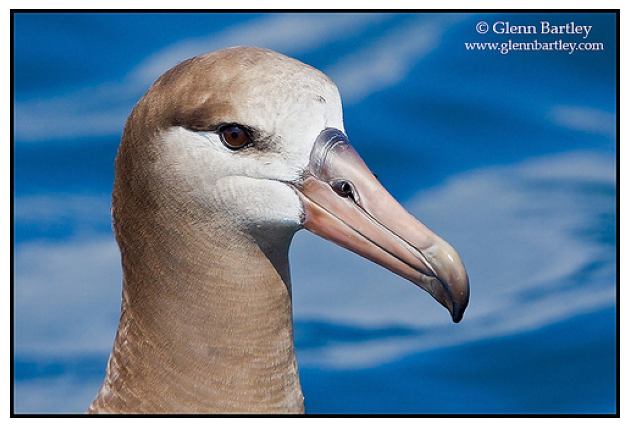

In [ ]:
%matplotlib inline
plt.figure()
plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.show()
plt.close('all')

In [ ]:
img_vis = transform_vis(img)
img_norm = transform_norm(img).to(device)

In [ ]:
model.patch_embed.grid_size

(14, 14)

In [ ]:
input_size

224

In [ ]:
def compute_token_similarity_sam(model, layer_idx, img_norm):
    
    out = get_specific_intermediate_layers_sam(model, img_norm.unsqueeze(0), layer_idx)
    
    
    attn_out = out/out.norm(dim=-1, keepdim=True)
    a, b = attn_out.clone(), attn_out.clone()
    scores = compute_dot_product_similarity(a,b).squeeze(0).detach().fill_diagonal_(-math.inf)
    return scores

In [ ]:
def compute_token_similarity(model, layer_idx, img_norm, return_key_similarity=False, return_attention_map=False, return_attention_rollout= False, model_type="vit", discard_ratio=0.5, head_fusion="min"):
    if model_type == "vit":
        if return_key_similarity:
            out, qkv = model.get_specific_intermediate_layer(img_norm.unsqueeze(0), layer_idx, return_qkv=True)
            q,k,v = qkv.unbind(0)
        
        elif return_attention_map:
            out, qkv = model.get_specific_intermediate_layer(img_norm.unsqueeze(0), layer_idx, return_qkv=True)
            attn_weight, _ = compute_attention(qkv)
        
        elif return_attention_rollout:
            out, attn_weights = model.get_specific_intermediate_layer(img_norm.unsqueeze(0), layer_idx, return_att_weights=True)
            
        
        else:
            out = model.get_specific_intermediate_layer(img_norm.unsqueeze(0), layer_idx, return_qkv=False)    
        
        if return_key_similarity:
            # key_vals = k.mean(dim=1)
            # key_vals = k / k.norm(dim=-1, keepdim=True)
            key_vals = torch.nn.functional.normalize(k, dim=-1)
            a, b = key_vals.clone(), key_vals.clone()     
            scores = compute_dot_product_similarity(a,b)
        elif return_attention_map:
            scores = attn_weight.detach()
        elif return_attention_rollout:
            scores = rollout(attn_weights, device=device, discard_ratio=discard_ratio, head_fusion=head_fusion)[0]
        else:
            
            # attn_out = out/out.norm(dim=-1, keepdim=True)
            attn_out  = torch.nn.functional.normalize(out, dim=-1)
            a, b = attn_out.clone(), attn_out.clone()
            scores = compute_dot_product_similarity(a,b).squeeze(0).detach().fill_diagonal_(-math.inf)
        return scores
    elif model_type == "samvit":
        return compute_token_similarity_sam(model, layer_idx, img_norm)

        

In [ ]:
def update_pixel_attention_map(layer_idx, img_norm, model, token_idx, alpha=0.6, return_key_similarity=False, return_attention_map=False, return_attention_rollout=False, axs=None, model_type="vit", discard_ratio=0.5, head_fusion="min"):
    if model_type == "vit":
        scores = compute_token_similarity(model= model, layer_idx=layer_idx, img_norm=img_norm, return_key_similarity=return_key_similarity, return_attention_map=return_attention_map, return_attention_rollout=return_attention_rollout, model_type=model_type, discard_ratio=discard_ratio, head_fusion=head_fusion)
        
        if return_attention_map or return_key_similarity:
            for i,axes in enumerate(axs.ravel()):
                if i<scores.shape[1]:
                    attn_weight_curr_head = scores[0,i].detach().clone().fill_diagonal_(-math.inf).cpu()
                    axes.imshow(attn_weight_curr_head[token_idx,model.num_prefix_tokens:].reshape(model.h_fmap, model.w_fmap), cmap='cet_rainbow4')
                    axes.axis('off')
                    axes.set_title(f'Head {i+1}')
                elif i==scores.shape[1]:
                    avg_attention_map = scores.mean(dim=1).squeeze(0).detach().fill_diagonal_(-math.inf).cpu()
                    axes.imshow(avg_attention_map[token_idx,model.num_prefix_tokens:].detach().reshape(model.h_fmap, model.w_fmap), cmap='cet_rainbow4')
                    axes.axis('off')
                    axes.set_title(f'Avg. Att. Map')
                elif i==scores.shape[1]+1:
                    axes.imshow(img_vis, alpha=alpha)
                    axes.imshow(cv2.resize(avg_attention_map[token_idx,model.num_prefix_tokens:].detach().reshape(model.h_fmap, model.w_fmap).cpu().numpy(), (input_size, input_size), interpolation=cv2.INTER_NEAREST), cmap='cet_rainbow4', alpha=1-alpha)
                    axes.axis('off')
                    axes.set_title(f'Image w Att.')
                elif i==scores.shape[1]+2:
                    axes.imshow(img_vis)
                    axes.axis('off')
                    axes.set_title(f'Image')

        else:
            token_amap = scores[token_idx,model.num_prefix_tokens:].reshape(model.h_fmap, model.w_fmap).to('cpu')
            axs[0].imshow(img_vis)
            axs[1].imshow(cv2.resize(token_amap.numpy(), (input_size, input_size), interpolation=cv2.INTER_NEAREST), cmap='cet_rainbow4')
            
            axs[2].imshow(img_vis, alpha=alpha)
            axs[2].imshow(cv2.resize(token_amap.numpy(), (input_size, input_size), interpolation=cv2.INTER_NEAREST), alpha=1-alpha, cmap='cet_rainbow4')
            axs[0].axis('off')
            axs[1].axis('off')
            axs[2].axis('off')
        
    elif model_type == "samvit":
        scores = compute_token_similarity(model= model, layer_idx=layer_idx, img_norm=img_norm, model_type=model_type)
        token_amap = scores[token_idx,:].reshape(model.h_fmap, model.w_fmap).to('cpu')
        axs[0].imshow(img_vis)
        axs[1].imshow(cv2.resize(token_amap.numpy(), (input_size, input_size), interpolation=cv2.INTER_NEAREST), cmap='cet_rainbow4')
            
        axs[2].imshow(img_vis, alpha=alpha)
        axs[2].imshow(cv2.resize(token_amap.numpy(), (input_size, input_size), interpolation=cv2.INTER_NEAREST), alpha=1-alpha, cmap='cet_rainbow4')
        axs[0].axis('off')
        axs[1].axis('off')
        axs[2].axis('off')
    fig.tight_layout()
    fig.canvas.draw_idle()

IntSlider(value=1, max=11, min=-1)

IntSlider(value=0, max=195)

FloatSlider(value=0.6, max=1.0, step=0.01)

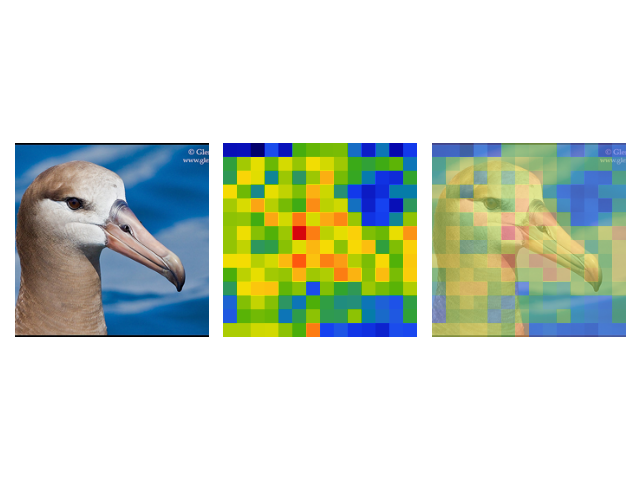

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

ValueError: n must be less than 12

In [ ]:
%matplotlib widget

layer_idx = 1
token_idx = 0
alpha = 0.6
# For SamViT, only patch token similarity is implemented
return_key_similarity = False
return_attention_map = False
return_attention_rollout = False
discard_ratio = 0.0
head_fusion = "min"

if model_type == "vit":
    scores_l1 = compute_token_similarity(model= model, layer_idx=layer_idx, img_norm=img_norm, return_key_similarity=return_key_similarity, return_attention_map=return_attention_map, return_attention_rollout=return_attention_rollout, model_type="vit", discard_ratio=discard_ratio, head_fusion=head_fusion)
average_attn_weight = compute_token_similarity(model= model, layer_idx=layer_idx, img_norm=img_norm, return_key_similarity=return_key_similarity, return_attention_map=return_attention_map, return_attention_rollout=return_attention_rollout, model_type=model_type, discard_ratio=discard_ratio, head_fusion=head_fusion)


if return_attention_map or return_key_similarity:
    num_plots_x = factors(scores_l1.shape[1])[-1]
    num_plots_y = factors(scores_l1.shape[1])[-2]
    fig, axs = plt.subplots(num_plots_x+ 1, num_plots_y, figsize=(10,10))
    
    for i,axes in enumerate(axs.ravel()):
        if i<scores_l1.shape[1]:
            attn_weight_curr_head = scores_l1[0,i].detach().clone().fill_diagonal_(-math.inf).cpu()
            axes.imshow(attn_weight_curr_head[token_idx,model.num_prefix_tokens:].reshape(model.h_fmap, model.w_fmap), cmap='cet_rainbow4')
            axes.axis('off')
            axes.set_title(f'Head {i+1}')
        elif i==scores_l1.shape[1]:
            avg_attention_map = scores_l1.mean(dim=1).squeeze(0).detach().fill_diagonal_(-math.inf).cpu()
            axes.imshow(avg_attention_map[token_idx,model.num_prefix_tokens:].detach().reshape(model.h_fmap, model.w_fmap), cmap='cet_rainbow4')
            axes.axis('off')
            axes.set_title(f'Avg. Att. Map')
        elif i==scores_l1.shape[1]+1:
            axes.imshow(img_vis, alpha=alpha)
            axes.imshow(cv2.resize(avg_attention_map[token_idx,model.num_prefix_tokens:].detach().reshape(model.h_fmap, model.w_fmap).cpu().numpy(), (input_size, input_size), interpolation=cv2.INTER_NEAREST), cmap='cet_rainbow4', alpha=1-alpha)
            axes.axis('off')
            axes.set_title(f'Image w Att.') 
        elif i==scores_l1.shape[1]+2:
            axes.imshow(img_vis)
            axes.axis('off')
            axes.set_title(f'Image')
    fig.tight_layout()
else:
    fig, axs = plt.subplots(1,3)
        
    plot = axs[0].imshow(img_vis)
    if model_type == "vit":
        token_amap = average_attn_weight[token_idx,model.num_prefix_tokens:].reshape(model.h_fmap, model.w_fmap).to('cpu')
    elif model_type == "samvit":
        token_amap = average_attn_weight[token_idx,:].reshape(model.h_fmap, model.w_fmap).to('cpu')
    plot_1 = axs[1].imshow(cv2.resize(token_amap.numpy(), (input_size, input_size), interpolation=cv2.INTER_NEAREST), cmap='cet_rainbow4')


    plot_2 = axs[2].imshow(img_vis, alpha=alpha)

    plot_3 =axs[2].imshow(cv2.resize(token_amap.numpy(), (input_size, input_size), interpolation=cv2.INTER_NEAREST), alpha=1-alpha, cmap='cet_rainbow4')
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    fig.tight_layout()

# Create a slider
if return_key_similarity or return_attention_map or return_attention_rollout:  
    layer_slider = widgets.IntSlider(min=0, max=len(model.blocks)-1, step=1, value=layer_idx)
else:
    layer_slider = widgets.IntSlider(min=-1, max=len(model.blocks)-1, step=1, value=layer_idx)
token_slider = widgets.IntSlider(min=0, max=((model.h_fmap*model.w_fmap)-1), step=1, value=token_idx)
alpha_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=alpha)

# Create a callback function for the widget
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        layer_idx = change['new']
        token_idx = token_slider.value
        alpha = alpha_slider.value
        update_pixel_attention_map(layer_idx, img_norm, model, token_idx=token_idx, alpha=alpha, return_key_similarity=return_key_similarity, return_attention_map=return_attention_map, return_attention_rollout=return_attention_rollout, axs=axs, model_type=model_type, discard_ratio=discard_ratio, head_fusion=head_fusion)

# Tell the slider to call on_change() when its value changes
layer_slider.observe(on_change)
token_slider.observe(on_change)
alpha_slider.observe(on_change)

# Display the slider and its label in a horizontal box
display(layer_slider)
display(token_slider)
display(alpha_slider)

# Display the figure
plt.show()